# Benchmark

In [1]:
import json
import requests
from datasets import load_dataset
from typing import Dict, List, Any, Optional
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from collections import defaultdict

# Configuration
ML_SERVICE_URL = "http://localhost/api/v1/ml"
ID_MAPPING_PATH = "data/id_mapping.json"

## 1. Load dataset

In [2]:
with open(ID_MAPPING_PATH, "r") as f:
    id_mapping = json.load(f)

arxiv_to_our_id = {v: k for k, v in id_mapping.items()}

print(f"Loaded {len(id_mapping)} papers from mapping")
print(list(id_mapping.items())[:5])

Loaded 200 papers from mapping
[('001', '1811.09786'), ('002', '2001.01589'), ('003', '1811.00942'), ('004', '1606.04631'), ('005', '1701.03214')]


In [3]:
qasper = load_dataset("allenai/qasper", split="train")

qasper.features.keys()

dict_keys(['id', 'title', 'abstract', 'full_text', 'qas', 'figures_and_tables'])

In [4]:
# Filter QASPER to only papers we have indexed
arxiv_ids = set(id_mapping.values())
filtered_papers = [paper for paper in qasper if paper["id"] in arxiv_ids]

# Show sample
if filtered_papers:
    sample = filtered_papers[0]
    print(f"\nSample paper ID: {sample['id']}")
    print(f"Title: {sample['title']}")
    print(f"Number of QAs: {len(sample['qas']['question'])}")
    print(len(filtered_papers))


Sample paper ID: 1909.00694
Title: Minimally Supervised Learning of Affective Events Using Discourse Relations
Number of QAs: 9
200


## 2. Transform Local Questions to Global Questions

QASPER questions are paper-specific (e.g., "What method do they use?"). 
We need to transform them to include paper context for global retrieval.

In [5]:
def transform_to_global_question(question: str, paper_title: str) -> str:
    replacements = [
        ("they use", f"the paper '{paper_title}' use"),
        ("they propose", f"the paper '{paper_title}' propose"),
        ("they achieve", f"the paper '{paper_title}' achieve"),
        ("this paper", f"the paper '{paper_title}'"),
        ("the paper", f"the paper '{paper_title}'"),
        ("the authors", f"the authors of '{paper_title}'"),
    ]
    
    global_question = question

    if paper_title.lower() not in question.lower():
        replaced = False
        for old, new in replacements:
            if old.lower() in question.lower():
                global_question = question.replace(old, new).replace(old.capitalize(), new)
                replaced = True
                break

        if not replaced:
            global_question = f"In the paper '{paper_title}': {question}"
    
    return global_question


test_questions = [
    "What method do they use?",
    "What datasets are used?",
    "What is the main contribution?",
    "How do they evaluate their approach?",
]

print("Question Transformations:")
for q in test_questions:
    transformed = transform_to_global_question(q, "PAPER TITLE")
    print(f"  Original: {q}")
    print(f"  Global:   {transformed}\n")

Question Transformations:
  Original: What method do they use?
  Global:   What method do the paper 'PAPER TITLE' use?

  Original: What datasets are used?
  Global:   In the paper 'PAPER TITLE': What datasets are used?

  Original: What is the main contribution?
  Global:   In the paper 'PAPER TITLE': What is the main contribution?

  Original: How do they evaluate their approach?
  Global:   In the paper 'PAPER TITLE': How do they evaluate their approach?



In [6]:
def extract_evidence_texts(paper: Dict) -> List[str]:
    evidence_texts = []
    
    for answers in paper["qas"]["answers"]:
        for answer in answers["answer"]:
            if answer.get("highlighted_evidence"):
                evidence_texts.extend(answer["highlighted_evidence"])
            if answer.get("extractive_spans"):
                evidence_texts.extend(answer["extractive_spans"])
    
    return list(set(evidence_texts))


def prepare_benchmark_dataset(papers: List[Dict], max_questions_per_paper: int = 5) -> List[Dict]:
    """
    Prepare benchmark dataset for both retrieval and generation evaluation.
    
    QASPER structure for answers:
    - answers["answer"] is a list of annotator answers
    - Each answer has: free_form_answer, extractive_spans, highlighted_evidence, evidence, yes_no, unanswerable
    """
    benchmark_data = []
    
    for paper in papers:
        arxiv_id = paper["id"]
        our_id = arxiv_to_our_id.get(arxiv_id)
        title = paper["title"]
        
        if not our_id:
            continue
        
        questions = paper["qas"]["question"]
        answers_list = paper["qas"]["answers"]
        
        for i, (question, answers) in enumerate(zip(questions, answers_list)):
            if i >= max_questions_per_paper:
                break
            
            evidence = []
            reference_answers = []
            
            for answer in answers["answer"]:
                # Skip unanswerable questions
                if answer.get("unanswerable", False):
                    continue
                    
                # Collect evidence for retrieval benchmark
                if answer.get("highlighted_evidence"):
                    evidence.extend(answer["highlighted_evidence"])
                if answer.get("extractive_spans"):
                    evidence.extend(answer["extractive_spans"])
                
                # Collect free-form answers for generation benchmark
                free_form = answer.get("free_form_answer", "")
                if free_form and free_form.strip():
                    reference_answers.append(free_form.strip())
                
                # Also use extractive spans as potential reference answers
                if answer.get("extractive_spans"):
                    for span in answer["extractive_spans"]:
                        if span and span.strip():
                            reference_answers.append(span.strip())
            
            # Skip if no evidence (for retrieval) or no answers (for generation)
            if not evidence:
                continue
            
            global_question = transform_to_global_question(question, title)
            
            benchmark_data.append({
                "paper_id": our_id,
                "arxiv_id": arxiv_id,
                "paper_title": title,
                "question": question,  # Original question
                "original_question": question,
                "global_question": global_question,
                "ground_truth_evidence": list(set(evidence)),
                "reference_answers": list(set(reference_answers)),  # For generation benchmark
            })
    
    return benchmark_data


benchmark_dataset = prepare_benchmark_dataset(filtered_papers, max_questions_per_paper=5)
print(f"Prepared {len(benchmark_dataset)} benchmark questions")

if benchmark_dataset:
    sample = benchmark_dataset[0]
    print(f"\nSample benchmark entry:")
    print(f"  Paper: {sample['paper_title'][:60]}...")
    print(f"  Original Q: {sample['original_question']}")
    print(f"  Global Q: {sample['global_question']}")
    print(f"  Evidence count: {len(sample['ground_truth_evidence'])}")
    print(f"  Reference answers: {len(sample['reference_answers'])}")
    if sample['reference_answers']:
        print(f"  First answer: {sample['reference_answers'][0][:150]}...")

Prepared 675 benchmark questions

Sample benchmark entry:
  Paper: Minimally Supervised Learning of Affective Events Using Disc...
  Original Q: What is the seed lexicon?
  Global Q: In the paper 'Minimally Supervised Learning of Affective Events Using Discourse Relations': What is the seed lexicon?
  Evidence count: 3
  Reference answers: 2
  First answer: seed lexicon consists of positive and negative predicates...


## 3. Query RAPTOR Search Endpoint

In [7]:
def query_raptor_search(query: str, mode = "raptor") -> List[Dict]:
    try:
        response = requests.get(
            f"{ML_SERVICE_URL}/raptor_search",
            params={"query": query, "mode": mode},
            timeout=30
        )

        response.raise_for_status()

        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"Error querying RAPTOR: {e}")
        return []


test_query = "What is the main contribution of BERT?"
test_results = query_raptor_search(test_query)
print(f"Test query: '{test_query}'")
print(f"Retrieved {len(test_results)} chunks")

if test_results:
    print(f"\nFirst result preview:")
    print(f"  Score: {test_results[0].get('score', 'N/A')}")
    print(f"  Text: {test_results[0].get('text', '')[:200]}...")

Test query: 'What is the main contribution of BERT?'
Retrieved 20 chunks

First result preview:
  Score: 0.7836710926821076
  Text: We show that adding BERTRAM to BERT
achieves a new state-of-the-art on WNLaM-
Pro (Schick and Sch ¨utze, 2020) and beats all
baselines on rariﬁed AG’s News, MNLI and
DBPedia, resulting in an absolute...


## 4. Calculate Retrieval Metrics

Metrics:
- **Recall@K**: Fraction of relevant evidence retrieved in top K results
- **MRR (Mean Reciprocal Rank)**: Average of reciprocal ranks of first relevant result  
- **Hit@K**: Whether any relevant evidence appears in top K results
- **NDCG@K**: Normalized Discounted Cumulative Gain

In [8]:
def calculate_text_overlap(retrieved_text: str, evidence_texts: List[str], threshold: float = 0.3) -> bool:
    retrieved_words = set(retrieved_text.lower().split())
    
    for evidence in evidence_texts:
        evidence_words = set(evidence.lower().split())
        
        if not evidence_words:
            continue
        
        intersection = len(retrieved_words & evidence_words)
        union = len(retrieved_words | evidence_words)
        
        if union > 0:
            overlap = intersection / len(evidence_words)
            if overlap >= threshold:
                return True
    
    return False


def calculate_metrics(
    benchmark_data: List[Dict],
    k_values: List[int] = [1, 5, 10, 20],
    overlap_threshold: float = 0.3,
    mode: str = "raptor"
) -> Dict[str, Any]:
    results = {
        "total_queries": len(benchmark_data),
        "k_values": k_values,
        "recall": {k: [] for k in k_values},
        "hit": {k: [] for k in k_values},
        "mrr": [],
        "per_query_results": [],
    }
    
    for item in tqdm(benchmark_data, desc="Evaluating queries"):
        query = item["global_question"]
        ground_truth = item["ground_truth_evidence"]
        expected_paper_id = item["paper_id"]
        
        retrieved = query_raptor_search(query, mode=mode)
        
        if not retrieved:
            for k in k_values:
                results["recall"][k].append(0.0)
                results["hit"][k].append(0)
            results["mrr"].append(0.0)
            continue
        
        relevance = []
        first_relevant_rank = None
        
        for rank, chunk in enumerate(retrieved, 1):
            chunk_text = chunk.get("text", "")
            is_relevant = calculate_text_overlap(chunk_text, ground_truth, overlap_threshold)
            relevance.append(is_relevant)
            
            if is_relevant and first_relevant_rank is None:
                first_relevant_rank = rank
        
        if first_relevant_rank:
            results["mrr"].append(1.0 / first_relevant_rank)
        else:
            results["mrr"].append(0.0)
        
        for k in k_values:
            top_k_relevant = sum(relevance[:k])
            
            recall = top_k_relevant / max(len(ground_truth), 1)
            results["recall"][k].append(min(recall, 1.0))
            
            results["hit"][k].append(1 if any(relevance[:k]) else 0)
        
        results["per_query_results"].append({
            "query": query,
            "paper_id": expected_paper_id,
            "retrieved_count": len(retrieved),
            "relevant_count": sum(relevance),
            "first_relevant_rank": first_relevant_rank,
        })
    
    results["aggregated"] = {
        "MRR": np.mean(results["mrr"]),
    }
    
    for k in k_values:
        results["aggregated"][f"Recall@{k}"] = np.mean(results["recall"][k])
        results["aggregated"][f"Hit@{k}"] = np.mean(results["hit"][k])
    
    return results

## 5. Run Benchmark

In [ ]:
SAMPLE_SIZE = None

print(f"Running benchmark on all {len(benchmark_dataset)} questions")

metrics = calculate_metrics(
    benchmark_dataset,
    k_values=[1, 5, 10, 20],
)

Running benchmark on all 675 questions


Evaluating queries:   0%|          | 0/675 [00:00<?, ?it/s]

In [22]:
# Display results
print("=" * 60)
print("RAPTOR Retrieval Benchmark Results")
print("=" * 60)
print(f"\nTotal queries evaluated: {metrics['total_queries']}")
print(f"\n{'Metric':<15} {'Value':>10}")
print("-" * 30)

for metric_name, value in metrics["aggregated"].items():
    print(f"{metric_name:<15} {value:>10.4f}")

print("\n" + "=" * 60)

RAPTOR Retrieval Benchmark Results

Total queries evaluated: 675

Metric               Value
------------------------------
MRR                 0.4412
Recall@1            0.1131
Hit@1               0.2519
Recall@5            0.5208
Hit@5               0.6741
Recall@10           0.6997
Hit@10              0.7941
Recall@20           0.7919
Hit@20              0.8504



In [23]:
# Create detailed results DataFrame
results_df = pd.DataFrame(metrics["per_query_results"])
print(f"\nPer-query statistics:")
print(results_df.describe())




Per-query statistics:
       retrieved_count  relevant_count  first_relevant_rank
count            675.0      675.000000           574.000000
mean              20.0        5.734815             3.689895
std                0.0        5.244685             3.692547
min               20.0        0.000000             1.000000
25%               20.0        1.000000             1.000000
50%               20.0        4.000000             2.000000
75%               20.0        9.000000             5.000000
max               20.0       20.000000            19.000000


## 6. Visualize Results

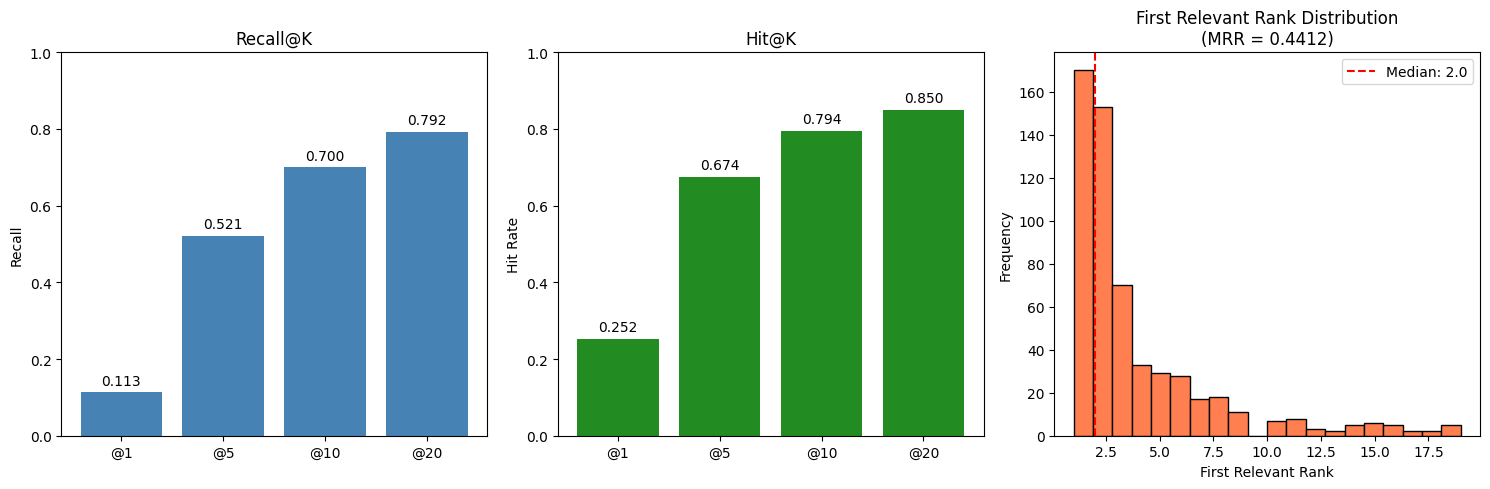


Plot saved to raptor_benchmark_results.png


In [24]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Recall@K
k_values = metrics["k_values"]
recall_values = [metrics["aggregated"][f"Recall@{k}"] for k in k_values]
axes[0].bar([f"@{k}" for k in k_values], recall_values, color='steelblue')
axes[0].set_ylabel("Recall")
axes[0].set_title("Recall@K")
axes[0].set_ylim(0, 1)
for i, v in enumerate(recall_values):
    axes[0].text(i, v + 0.02, f"{v:.3f}", ha='center', fontsize=10)

# Hit@K
hit_values = [metrics["aggregated"][f"Hit@{k}"] for k in k_values]
axes[1].bar([f"@{k}" for k in k_values], hit_values, color='forestgreen')
axes[1].set_ylabel("Hit Rate")
axes[1].set_title("Hit@K")
axes[1].set_ylim(0, 1)
for i, v in enumerate(hit_values):
    axes[1].text(i, v + 0.02, f"{v:.3f}", ha='center', fontsize=10)

# First Relevant Rank Distribution
valid_ranks = results_df[results_df["first_relevant_rank"].notna()]["first_relevant_rank"]
if len(valid_ranks) > 0:
    axes[2].hist(valid_ranks, bins=20, color='coral', edgecolor='black')
    axes[2].set_xlabel("First Relevant Rank")
    axes[2].set_ylabel("Frequency")
    axes[2].set_title(f"First Relevant Rank Distribution\n(MRR = {metrics['aggregated']['MRR']:.4f})")
    axes[2].axvline(valid_ranks.median(), color='red', linestyle='--', label=f'Median: {valid_ranks.median():.1f}')
    axes[2].legend()
else:
    axes[2].text(0.5, 0.5, "No relevant results found", ha='center', va='center', transform=axes[2].transAxes)
    axes[2].set_title("First Relevant Rank Distribution")

plt.tight_layout()
plt.savefig("raptor_benchmark_results.png", dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to raptor_benchmark_results.png")

## 7. Save Benchmark Results

In [ ]:
import datetime

benchmark_output = {
    "timestamp": datetime.datetime.now().isoformat(),
    "config": {
        "sample_size": SAMPLE_SIZE,
        "k_values": metrics["k_values"],
        "ml_service_url": ML_SERVICE_URL,
    },
    "metrics": metrics["aggregated"],
    "per_query_summary": {
        "total_queries": len(results_df),
        "queries_with_relevant": len(results_df[results_df["first_relevant_rank"].notna()]),
        "avg_retrieved": results_df["retrieved_count"].mean(),
        "avg_relevant": results_df["relevant_count"].mean(),
    }
}

with open("raptor_benchmark_results.json", "w") as f:
    json.dump(benchmark_output, f, indent=2)

print(json.dumps(benchmark_output, indent=2))

{
  "timestamp": "2025-12-06T03:20:15.965270",
  "config": {
    "sample_size": null,
    "k_values": [
      1,
      5,
      10,
      20
    ],
    "ml_service_url": "http://localhost/api/v1/ml"
  },
  "metrics": {
    "MRR": 0.4259504800961629,
    "Recall@1": 0.12999601838490726,
    "Hit@1": 0.28888888888888886,
    "Recall@5": 0.45028381700603926,
    "Hit@5": 0.6044444444444445,
    "Recall@10": 0.5871253273475496,
    "Hit@10": 0.6933333333333334,
    "Recall@20": 0.6845460958794292,
    "Hit@20": 0.7570370370370371
  },
  "per_query_summary": {
    "total_queries": 675,
    "queries_with_relevant": 511,
    "avg_retrieved": 20.0,
    "avg_relevant": 4.694814814814815
  }
}


## 8. Answer Generation Benchmark (LLM /ask endpoint)

Benchmark the full RAG pipeline using F1 (token overlap) and BLEU scores.

In [9]:
from collections import Counter
import re
import string
from typing import Optional
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import nltk

# Download required NLTK data (run once)
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

def tokenize_text(text: str) -> list:
    """Tokenize text for metric calculation."""
    text = text.lower()
    text = re.sub(f'[{re.escape(string.punctuation)}]', ' ', text)
    return text.split()

def bleu_score(reference: str, candidate: str, max_n: int = 4) -> float:
    ref_tokens = tokenize_text(reference)
    cand_tokens = tokenize_text(candidate)
    
    if len(cand_tokens) == 0 or len(ref_tokens) == 0:
        return 0.0

    references = [ref_tokens]

    smoothing = SmoothingFunction().method1

    weights = tuple([1.0/max_n] * max_n)
    
    try:
        score = sentence_bleu(references, cand_tokens, weights=weights, smoothing_function=smoothing)
        return score
    except Exception as e:
        print(f"BLEU calculation error: {e}")
        return 0.0

def f1_token_overlap(reference: str, candidate: str) -> dict:
    """
    Calculate F1 score based on token overlap between reference and candidate.
    Returns precision, recall, and F1.
    """
    ref_tokens = set(tokenize_text(reference))
    cand_tokens = set(tokenize_text(candidate))
    
    if len(cand_tokens) == 0:
        return {"precision": 0.0, "recall": 0.0, "f1": 0.0}
    
    if len(ref_tokens) == 0:
        return {"precision": 0.0, "recall": 0.0, "f1": 0.0}
    
    overlap = ref_tokens & cand_tokens
    
    precision = len(overlap) / len(cand_tokens)
    recall = len(overlap) / len(ref_tokens)
    
    if precision + recall == 0:
        f1 = 0.0
    else:
        f1 = 2 * (precision * recall) / (precision + recall)
    
    return {"precision": precision, "recall": recall, "f1": f1}

In [15]:
def query_ask_endpoint(question: str, paper_id: str, uuid: str = "benchmark-user", benchmark: bool = True) -> Optional[str]:
    """
    Query the /ask endpoint to get LLM-generated answer.
    
    Args:
        question: The question to ask
        paper_id: The paper/assignment ID for context
        uuid: User identifier
        benchmark: If True, skip chat history (default True for benchmarking)
        
    Returns:
        Generated answer string or None if failed
    """
    try:
        response = requests.post(
            f"{ML_SERVICE_URL}/ask",
            json={
                "uuid": uuid,
                "assignment_id": paper_id,
                "content": question,
                "benchmark": benchmark  # Skip chat history for fair benchmarking
            },
            timeout=180  # LLM calls can be slow
        )
        
        if response.status_code == 200:
            data = response.json()
            return data.get("content", "")
        else:
            print(f"Error {response.status_code}: {response.text[:200]}")
            return None
    except Exception as e:
        print(f"Request failed: {e}")
        return None

test_question = "What is the main contribution of this paper?"
test_paper = benchmark_dataset[0]["paper_id"] if benchmark_dataset else "test"
print(f"Testing /ask endpoint with paper: {test_paper}")
test_answer = query_ask_endpoint(test_question, test_paper, benchmark=True)
print(f"Answer: {test_answer[:500] if test_answer else 'No response'}...")

Testing /ask endpoint with paper: 189
Answer: The **main contribution** of the paper **"Minimally Supervised Learning of Affective Events Using Discourse Relations"** is the **effective propagation of affective polarity** from a **small seed lexicon** to a **large unlabeled corpus** using **discourse relations**. 

### **Key Findings**  
- **Discourse relations** (e.g., causal, contrastive, temporal) are **powerful tools** for propagating affective polarity.  
- The method achieves **strong performance** with **minimal supervision** (a tiny...
Answer: The **main contribution** of the paper **"Minimally Supervised Learning of Affective Events Using Discourse Relations"** is the **effective propagation of affective polarity** from a **small seed lexicon** to a **large unlabeled corpus** using **discourse relations**. 

### **Key Findings**  
- **Discourse relations** (e.g., causal, contrastive, temporal) are **powerful tools** for propagating affective polarity.  
- The method achieves *

In [16]:
import time

def run_generation_benchmark(benchmark_items: list, delay: float = 1.0) -> list:
    """
    Run generation benchmark by querying /ask endpoint for each question.
    
    Args:
        benchmark_items: List of benchmark items with global_question and reference_answers
        delay: Delay between requests in seconds (to avoid rate limiting)
        
    Returns:
        List of results with generated answers and scores
    """
    results = []
    skipped = 0
    
    for i, item in enumerate(tqdm(benchmark_items, desc="Running generation benchmark")):
        # Skip items without reference answers
        if not item.get("reference_answers"):
            skipped += 1
            continue
            
        generated_answer = query_ask_endpoint(
            question=item["global_question"],
            paper_id=item["paper_id"]
        )
        
        if generated_answer is None:
            generated_answer = ""

        best_f1 = {"precision": 0, "recall": 0, "f1": 0}
        best_bleu = 0.0
        all_f1_scores = []
        all_bleu_scores = []
        
        for ref_answer in item["reference_answers"]:
            f1_result = f1_token_overlap(ref_answer, generated_answer)
            all_f1_scores.append(f1_result["f1"])
            if f1_result["f1"] > best_f1["f1"]:
                best_f1 = f1_result
            
            bleu = bleu_score(ref_answer, generated_answer)
            all_bleu_scores.append(bleu)
            if bleu > best_bleu:
                best_bleu = bleu

        results.append({
            "paper_id": item["paper_id"],
            "paper_title": item["paper_title"],
            "question": item["global_question"],
            "original_question": item.get("original_question", item.get("question", "")),
            "generated_answer": generated_answer,
            "reference_answers": item["reference_answers"],
            "best_f1": best_f1,
            "best_bleu": best_bleu,
            "avg_f1": sum(all_f1_scores) / len(all_f1_scores) if all_f1_scores else 0,
            "avg_bleu": sum(all_bleu_scores) / len(all_bleu_scores) if all_bleu_scores else 0,
        })
        
        # Delay to avoid rate limiting
        if delay > 0 and i < len(benchmark_items) - 1:
            time.sleep(delay)
    
    if skipped > 0:
        print(f"Skipped {skipped} items without reference answers")
    
    return results

In [ ]:

print(f"Running generation benchmark on {len(benchmark_dataset)} samples...")
print("This may take several minutes due to LLM response times.\n")

generation_results = run_generation_benchmark(benchmark_dataset, delay=0.5)

Running generation benchmark on 675 samples...
This may take several minutes due to LLM response times.



Running generation benchmark:   0%|          | 0/675 [00:00<?, ?it/s]

In [ ]:
# Calculate aggregate generation metrics
def calculate_generation_metrics(results: list) -> dict:
    """Calculate aggregate metrics from generation benchmark results."""
    if not results:
        return {}
    
    # Extract scores
    best_f1_scores = [r["best_f1"]["f1"] for r in results]
    best_bleu_scores = [r["best_bleu"] for r in results]
    avg_f1_scores = [r["avg_f1"] for r in results]
    avg_bleu_scores = [r["avg_bleu"] for r in results]
    
    precision_scores = [r["best_f1"]["precision"] for r in results]
    recall_scores = [r["best_f1"]["recall"] for r in results]
    
    return {
        "num_samples": len(results),
        "best_f1": {
            "mean": sum(best_f1_scores) / len(best_f1_scores),
            "min": min(best_f1_scores),
            "max": max(best_f1_scores),
            "std": (sum((x - sum(best_f1_scores)/len(best_f1_scores))**2 for x in best_f1_scores) / len(best_f1_scores))**0.5
        },
        "avg_f1": {
            "mean": sum(avg_f1_scores) / len(avg_f1_scores),
        },
        "precision": {
            "mean": sum(precision_scores) / len(precision_scores),
        },
        "recall": {
            "mean": sum(recall_scores) / len(recall_scores),
        },
        "best_bleu": {
            "mean": sum(best_bleu_scores) / len(best_bleu_scores),
            "min": min(best_bleu_scores),
            "max": max(best_bleu_scores),
            "std": (sum((x - sum(best_bleu_scores)/len(best_bleu_scores))**2 for x in best_bleu_scores) / len(best_bleu_scores))**0.5
        },
        "avg_bleu": {
            "mean": sum(avg_bleu_scores) / len(avg_bleu_scores),
        }
    }

generation_metrics = calculate_generation_metrics(generation_results)

print("=" * 60)
print("GENERATION BENCHMARK RESULTS")
print("=" * 60)
print(f"\nNumber of samples: {generation_metrics.get('num_samples', 0)}")
print(f"\n--- F1 Token Overlap (Best Match) ---")
print(f"  Mean F1:        {generation_metrics['best_f1']['mean']:.4f}")
print(f"  Mean Precision: {generation_metrics['precision']['mean']:.4f}")
print(f"  Mean Recall:    {generation_metrics['recall']['mean']:.4f}")
print(f"  Min/Max F1:     {generation_metrics['best_f1']['min']:.4f} / {generation_metrics['best_f1']['max']:.4f}")
print(f"  Std Dev:        {generation_metrics['best_f1']['std']:.4f}")
print(f"\n--- BLEU Score (Best Match) ---")
print(f"  Mean BLEU:      {generation_metrics['best_bleu']['mean']:.4f}")
print(f"  Min/Max BLEU:   {generation_metrics['best_bleu']['min']:.4f} / {generation_metrics['best_bleu']['max']:.4f}")
print(f"  Std Dev:        {generation_metrics['best_bleu']['std']:.4f}")
print("=" * 60)

In [ ]:
# Visualize generation benchmark results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# F1 Score Distribution
f1_scores = [r["best_f1"]["f1"] for r in generation_results]
axes[0].hist(f1_scores, bins=20, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(generation_metrics['best_f1']['mean'], color='red', linestyle='--', 
                label=f'Mean: {generation_metrics["best_f1"]["mean"]:.3f}')
axes[0].set_xlabel('F1 Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('F1 Token Overlap Distribution')
axes[0].legend()

# BLEU Score Distribution
bleu_scores = [r["best_bleu"] for r in generation_results]
axes[1].hist(bleu_scores, bins=20, edgecolor='black', alpha=0.7, color='seagreen')
axes[1].axvline(generation_metrics['best_bleu']['mean'], color='red', linestyle='--',
                label=f'Mean: {generation_metrics["best_bleu"]["mean"]:.3f}')
axes[1].set_xlabel('BLEU Score')
axes[1].set_ylabel('Frequency')
axes[1].set_title('BLEU Score Distribution')
axes[1].legend()

# F1 vs BLEU Scatter
axes[2].scatter(f1_scores, bleu_scores, alpha=0.6, c='purple')
axes[2].set_xlabel('F1 Score')
axes[2].set_ylabel('BLEU Score')
axes[2].set_title('F1 vs BLEU Correlation')

# Add correlation coefficient
import numpy as np
if len(f1_scores) > 1:
    correlation = np.corrcoef(f1_scores, bleu_scores)[0, 1]
    axes[2].annotate(f'r = {correlation:.3f}', xy=(0.05, 0.95), xycoords='axes fraction',
                     fontsize=12, ha='left', va='top')

plt.tight_layout()
plt.savefig('generation_benchmark_results.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nVisualization saved to 'generation_benchmark_results.png'")

In [ ]:
# Create detailed results DataFrame
generation_results_df = pd.DataFrame([
    {
        "paper_id": r["paper_id"],
        "paper_title": r["paper_title"][:50] + "...",
        "question": r["question"][:80] + "...",
        "generated_answer_preview": r["generated_answer"][:100] + "..." if r["generated_answer"] else "N/A",
        "f1_score": r["best_f1"]["f1"],
        "precision": r["best_f1"]["precision"],
        "recall": r["best_f1"]["recall"],
        "bleu_score": r["best_bleu"],
    }
    for r in generation_results
])

print("Generation Results Summary:")
print(generation_results_df.describe())
print("\n" + "="*60)
print("\nTop 5 Best F1 Scores:")
display(generation_results_df.nlargest(5, 'f1_score')[['question', 'f1_score', 'bleu_score']])

print("\nTop 5 Worst F1 Scores:")
display(generation_results_df.nsmallest(5, 'f1_score')[['question', 'f1_score', 'bleu_score']])

In [ ]:
# Save generation benchmark results
generation_output = {
    "timestamp": datetime.datetime.now().isoformat(),
    "config": {
        "num_samples": len(generation_benchmark),
        "model": "qwen/qwen3-32b (via Groq)",
        "retrieval_method": "RAPTOR top-down search"
    },
    "metrics": generation_metrics,
    "detailed_results": [
        {
            "paper_id": r["paper_id"],
            "question": r["question"],
            "generated_answer": r["generated_answer"],
            "reference_answers": r["reference_answers"],
            "f1": r["best_f1"],
            "bleu": r["best_bleu"]
        }
        for r in generation_results
    ]
}

with open("generation_benchmark_results.json", "w") as f:
    json.dump(generation_output, f, indent=2)

print("Generation benchmark results saved to 'generation_benchmark_results.json'")

## 9. Combined Benchmark Summary

Compare retrieval and generation metrics side by side.

In [ ]:
# Combined benchmark summary
print("=" * 70)
print("COMBINED BENCHMARK SUMMARY - RAPTOR RAG System")
print("=" * 70)

print("\n📊 RETRIEVAL METRICS (RAPTOR Top-Down Search)")
print("-" * 50)
if 'metrics' in dir():
    print(f"  Recall@5:    {metrics.get('recall@5', 'N/A'):.4f}" if isinstance(metrics.get('recall@5'), float) else f"  Recall@5:    {metrics.get('recall@5', 'N/A')}")
    print(f"  Recall@10:   {metrics.get('recall@10', 'N/A'):.4f}" if isinstance(metrics.get('recall@10'), float) else f"  Recall@10:   {metrics.get('recall@10', 'N/A')}")
    print(f"  Recall@20:   {metrics.get('recall@20', 'N/A'):.4f}" if isinstance(metrics.get('recall@20'), float) else f"  Recall@20:   {metrics.get('recall@20', 'N/A')}")
    print(f"  Hit@5:       {metrics.get('hit@5', 'N/A'):.4f}" if isinstance(metrics.get('hit@5'), float) else f"  Hit@5:       {metrics.get('hit@5', 'N/A')}")
    print(f"  Hit@10:      {metrics.get('hit@10', 'N/A'):.4f}" if isinstance(metrics.get('hit@10'), float) else f"  Hit@10:      {metrics.get('hit@10', 'N/A')}")
    print(f"  MRR:         {metrics.get('mrr', 'N/A'):.4f}" if isinstance(metrics.get('mrr'), float) else f"  MRR:         {metrics.get('mrr', 'N/A')}")

print("\n🤖 GENERATION METRICS (/ask endpoint with LLM)")
print("-" * 50)
if 'generation_metrics' in dir() and generation_metrics:
    print(f"  F1 Score (mean):       {generation_metrics['best_f1']['mean']:.4f}")
    print(f"  Precision (mean):      {generation_metrics['precision']['mean']:.4f}")
    print(f"  Recall (mean):         {generation_metrics['recall']['mean']:.4f}")
    print(f"  BLEU Score (mean):     {generation_metrics['best_bleu']['mean']:.4f}")
    print(f"  Samples evaluated:     {generation_metrics['num_samples']}")

print("\n" + "=" * 70)
print("Benchmark complete!")
print("=" * 70)